In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties
font_path = r"C:\Windows\Fonts\Sanskr.ttf"
font_prop = FontProperties(fname=font_path)

In [22]:
images_size =(200,200)

In [23]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./Hand_Landmark_Image/",
    color_mode='grayscale',
    image_size=images_size
)
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "./Hand_Landmark_Image/",
    validation_split=0.1,
    subset="training",
    seed=123,
    color_mode='grayscale',
    image_size=images_size
)
ds_validation= tf.keras.preprocessing.image_dataset_from_directory(
    "./Hand_Landmark_Image/",
    validation_split=0.1,
    subset="validation",
    seed=123,
    color_mode='grayscale',
    image_size=images_size
)

Found 100336 files belonging to 50 classes.
Found 100336 files belonging to 50 classes.
Using 90303 files for training.
Found 100336 files belonging to 50 classes.
Using 10033 files for validation.


In [38]:
import tensorflow_datasets as tfds
batch_size =16

dataset_name = dataset 
class_name = dataset.class_names


In [25]:
value = ['अ','आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ओ', 'औ','क' , 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ','ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ','ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह','क्ष', 'त्र', 'ज्ञ', 'श्र','्','्र']

In [26]:
def class_value(label):
    return value[int(label)]

ख


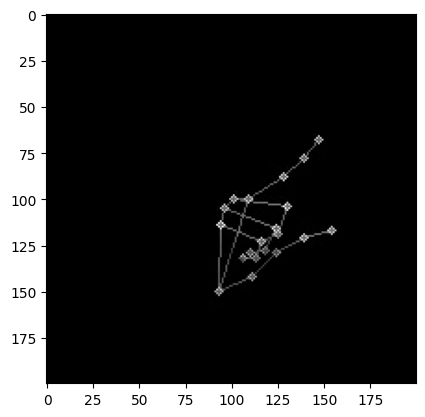

In [27]:
import matplotlib.pyplot as plt 
for image, labels in dataset_name:
    plt.imshow(image[0].numpy().astype("uint8"),cmap='gray')
    print(class_value(class_name[labels[0]]))
    break

In [28]:


val_batches = tf.data.experimental.cardinality(ds_validation)
test_dataset = ds_validation.take(val_batches // 5)
validation_dataset = ds_validation.skip(val_batches //5 )

In [29]:
len(validation_dataset)

252

In [30]:
size = (200,200)
ds_train = ds_train.map(lambda image,label:(tf.image.resize(image,size),label))
ds_val = ds_validation.map(lambda image,label:(tf.image.resize(image,size),label))
ds_test = test_dataset.map(lambda image,label:(tf.image.resize(image,size),label))


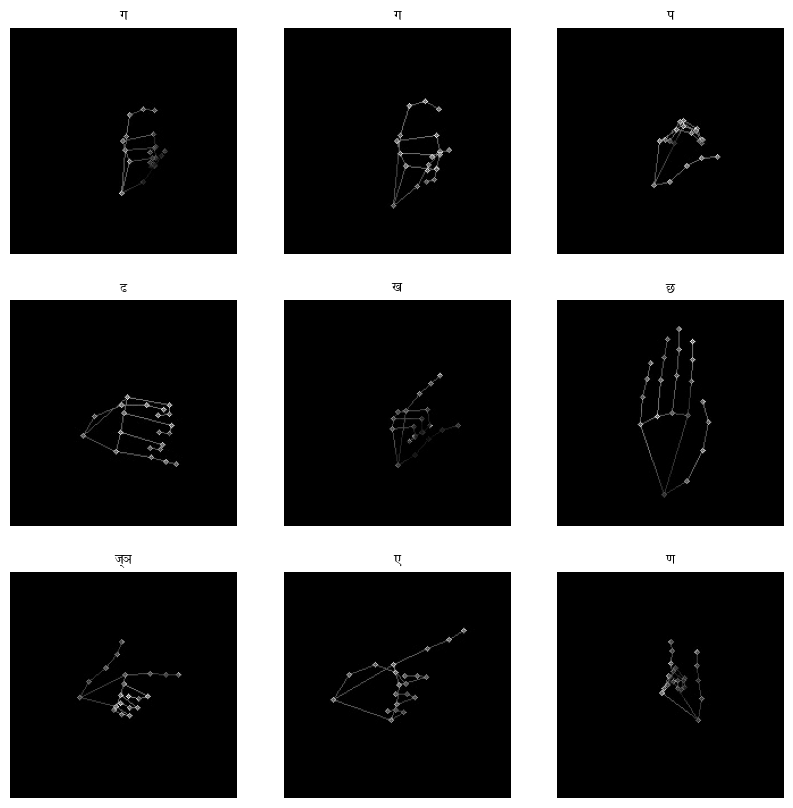

In [31]:
plt.figure(figsize=(10,10))
for images,labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
        plt.title(class_value(class_name[labels[i]]),fontproperties= font_prop)
        plt.axis("off")

In [32]:
NUM_CLASSES = len(class_name)

In [33]:
import tensorflow_addons as tfa

c:\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [34]:
def  input_preprocess(image,label):
    label = tf.one_hot(label,NUM_CLASSES)
    return image,label
ds_train = ds_train.map(input_preprocess,num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(input_preprocess)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

In [35]:
model =tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(200,200,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50,activation='softmax')
])

In [39]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.Precision(name='precision'),
                       tfa.metrics.F1Score(name='f1_score',num_classes=50)
                       ])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 99, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 64)        0

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
es = EarlyStopping(monitor ='val_accuracy',min_delta =0.01,patience=10,verbose =1)
model_cp = ModelCheckpoint(filepath="./modelCheck1.h5",
                           monitor='val_accuracy',
                           save_best_only = True,
                           save_weight_only = False,
                           verbose = 1)

In [43]:
epochs = 3
hist = model.fit(ds_train,epochs=epochs,validation_data=ds_val,callbacks=[model_cp,es],batch_size=16,verbose=1)

Epoch 1/3
  42/2822 [..............................] - ETA: 36:58 - loss: 6.2617 - accuracy: 0.2746 - recall: 0.0818 - precision: 0.3560 - f1_score: 0.2390

KeyboardInterrupt: 

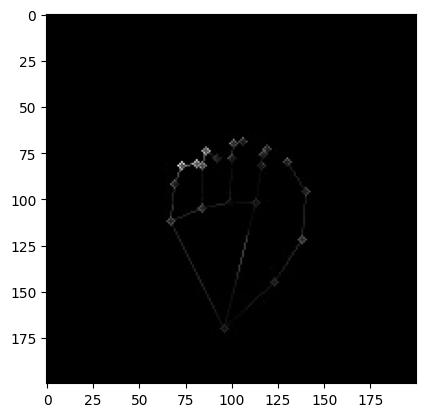

In [20]:
import cv2
photo = cv2.imread("./Hand_Landmark_Image/42/300.jpg",cv2.IMREAD_GRAYSCALE)
plt.imshow(photo,cmap="gray")


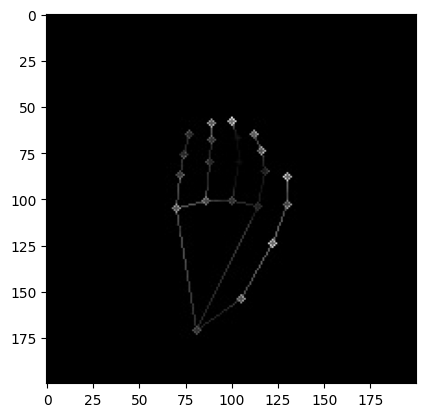